In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import (Dense,Activation)
from sklearn.model_selection import (train_test_split,
                                    RandomizedSearchCV,
                                    RepeatedStratifiedKFold,
                                    GridSearchCV
                                    )
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.callbacks import (History)
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            roc_auc_score, 
                            confusion_matrix,
                             mean_absolute_error,
                             mean_squared_error,
                             recall_score,
                             precision_score
                            )
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf

from keras.regularizers import l2

from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 5
sns.set_style('darkgrid')

In [2]:
patient_df = pd.read_csv('dataset.csv')
patient_df.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


In [3]:
patient_df.describe()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,Unnamed: 83,hospital_death
count,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,88993.000000,...,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,0.0,91713.000000
mean,65606.079280,65537.131464,105.669262,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,84.028340,...,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,NaN,0.086302
std,37795.088538,37811.252183,62.854406,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,25.011497,...,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,NaN,0.280811
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,38.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,32852.000000,32830.000000,47.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,66.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
50%,65665.000000,65413.000000,109.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,80.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
75%,98342.000000,98298.000000,161.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,97.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
max,131051.000000,131051.000000,204.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,186.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000


In [4]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

In [5]:
patient_df.drop(labels=['apache_3j_bodysystem','apache_2_bodysystem'], axis=1, inplace=True)
patient_df = pd.get_dummies(data=patient_df, columns=['ethnicity', 'gender','icu_admit_source','icu_stay_type','icu_type'], drop_first=True)
patient_df.drop(labels=['Unnamed: 83','encounter_id', 'patient_id', 'hospital_id', 'icu_id'], axis=1, inplace=True)
patient_df = patient_df.dropna()

In [6]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57598 entries, 0 to 91712
Data columns (total 92 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         57598 non-null  float64
 1   bmi                                         57598 non-null  float64
 2   elective_surgery                            57598 non-null  int64  
 3   height                                      57598 non-null  float64
 4   pre_icu_los_days                            57598 non-null  float64
 5   weight                                      57598 non-null  float64
 6   apache_2_diagnosis                          57598 non-null  float64
 7   apache_3j_diagnosis                         57598 non-null  float64
 8   apache_post_operative                       57598 non-null  int64  
 9   arf_apache                                  57598 non-null  float64
 10  gcs_eyes_a

In [7]:


RandomForestModelData = patient_df.copy()
y = RandomForestModelData['hospital_death']
X = RandomForestModelData.drop('hospital_death', axis = 1)
# doing scalar
scaled_features = StandardScaler().fit_transform(X.values)
X = pd.DataFrame(scaled_features, columns=RandomForestModelData.loc[:,RandomForestModelData.columns != "hospital_death"].columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (40318, 91)
Training Labels Shape: (40318,)
Testing Features Shape: (17280, 91)
Testing Labels Shape: (17280,)


In [ ]:
## DONT RUN UNLESS YOU WANT COMP TO BURN

# Optimize setting 
optimize = {'bootstrap': [True, False],
 'max_depth': [10,30,50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 1000, 1800, ]}

RandomForestModel = RandomForestRegressor()

RandomForestModel_Optimizer = RandomizedSearchCV(estimator = RandomForestModel,param_distributions = optimize,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
RandomForestModel_Optimizer.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [8]:
print ('Random grid: ', optimize, '\n')
# print the best parameters
print ('Best Parameters: ', RandomForestModel_Optimizer.best_params_, ' \n')

NameError: name 'optimize' is not defined

In [ ]:
RandomForestModelOptimized = RandomForestRegressor()
RandomForestModelOptimized.fit( X_train, y_train) 

In [ ]:
y_hat = RandomForestModel.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_hat)
print(classification_report(y_test, y_hat))

print("Mean Absolute Error: ", mean_absolute_error(y_test, y_hat))
print("Mean Square Error: ", mean_squared_error(y_test, y_hat))
print("Accuracy Score: ", accuracy_score(y_test, y_hat))
print("Recall Score: ", recall_score(y_test, y_hat, average=None))
print("precision Score: ", precision_score(y_test, y_hat, average=None))
print("AUC-ROC Curve: ", roc_auc_score(y_test, y_hat))

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [13]:
LogModedlData = patient_df.copy()
y = LogModedlData['hospital_death']
X = LogModedlData.drop('hospital_death', axis = 1)
# doing scalar
scaled_features = StandardScaler().fit_transform(X.values)
X = pd.DataFrame(scaled_features, columns=LogModedlData.loc[:,LogModedlData.columns != "hospital_death"].columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (40318, 91)
Training Labels Shape: (40318,)
Testing Features Shape: (17280, 91)
Testing Labels Shape: (17280,)


In [15]:
# define models and parameters
LogModel = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=LogModel, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train,y_train )

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.924988 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.924889 (0.002731) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.924914 (0.002701) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.924897 (0.002717) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.924914 (0.002713) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.924938 (0.002702) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.924914 (0.002713) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.924988 (0.002717) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.924955 (0.002753) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.924988 (0.002714) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.924914 (0.002710) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.924905 (0.002708) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.924938 (0.002694) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.924781 (0.002737) wit

In [20]:
LogModel = LogisticRegression(C = 1.0, penalty = "l2", solver= "newton-cg")
LogModel.fit(X_train,y_train)
y_hat = LogModel.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_hat)
print(classification_report(y_test, y_hat))

print("Mean Absolute Error: ", mean_absolute_error(y_test, y_hat))
print("Mean Square Error: ", mean_squared_error(y_test, y_hat))
print("Accuracy Score: ", accuracy_score(y_test, y_hat))
print("Recall Score: ", recall_score(y_test, y_hat, average=None))
print("precision Score: ", precision_score(y_test, y_hat, average=None))
print("AUC-ROC Curve: ", roc_auc_score(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     15787
           1       0.63      0.26      0.36      1493

    accuracy                           0.92     17280
   macro avg       0.78      0.62      0.66     17280
weighted avg       0.91      0.92      0.91     17280

Mean Absolute Error:  0.07731481481481481
Mean Square Error:  0.07731481481481481
Accuracy Score:  0.9226851851851852
Recall Score:  [0.98574777 0.25586068]
precision Score:  [0.93336532 0.62932455]
AUC-ROC Curve:  0.6208042251691992


<AxesSubplot:>

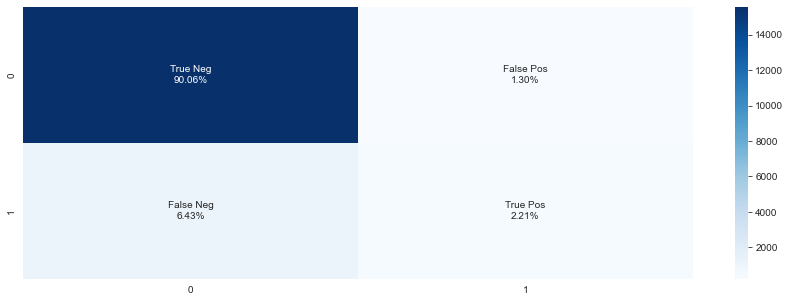

In [21]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [22]:
NeuralNetworkData = patient_df.copy()
y = NeuralNetworkData['hospital_death']
X = NeuralNetworkData.drop('hospital_death', axis = 1)
# doing scalar
scaled_features = StandardScaler().fit_transform(X.values)
X = pd.DataFrame(scaled_features, columns=NeuralNetworkData.loc[:,NeuralNetworkData.columns != "hospital_death"].columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (40318, 91)
Training Labels Shape: (40318,)
Testing Features Shape: (17280, 91)
Testing Labels Shape: (17280,)


In [25]:
NeuralNetwork = Sequential()
NeuralNetwork.add(Dense(91, input_dim=91, activation='relu'))
NeuralNetwork.add(Dense(60, activation='relu'))
NeuralNetwork.add(Dense(1,activation='sigmoid'))

opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
NeuralNetwork.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = NeuralNetwork.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50, batch_size=64)

Epoch 1/50
630/630 [==============================] - 2s 2ms/step - loss: 0.9548 - accuracy: 0.2515 - val_loss: 0.9346 - val_accuracy: 0.2648
Epoch 2/50
630/630 [==============================] - 1s 2ms/step - loss: 0.9163 - accuracy: 0.2855 - val_loss: 0.8976 - val_accuracy: 0.2995
Epoch 3/50
630/630 [==============================] - 1s 2ms/step - loss: 0.8805 - accuracy: 0.3207 - val_loss: 0.8631 - val_accuracy: 0.3366
Epoch 4/50
630/630 [==============================] - 1s 2ms/step - loss: 0.8471 - accuracy: 0.3573 - val_loss: 0.8311 - val_accuracy: 0.3744
Epoch 5/50
630/630 [==============================] - 1s 2ms/step - loss: 0.8161 - accuracy: 0.3959 - val_loss: 0.8013 - val_accuracy: 0.4134
Epoch 6/50
630/630 [==============================] - 1s 2ms/step - loss: 0.7873 - accuracy: 0.4352 - val_loss: 0.7735 - val_accuracy: 0.4508
Epoch 7/50
630/630 [==============================] - 1s 2ms/step - loss: 0.7604 - accuracy: 0.4726 - val_loss: 0.7478 - val_accuracy: 0.4903
Epoch 

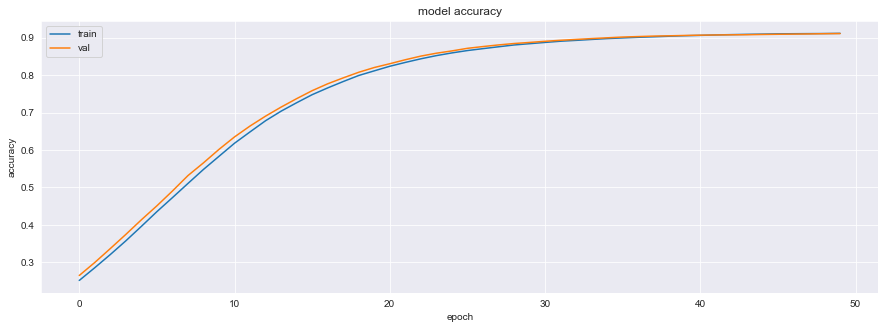

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

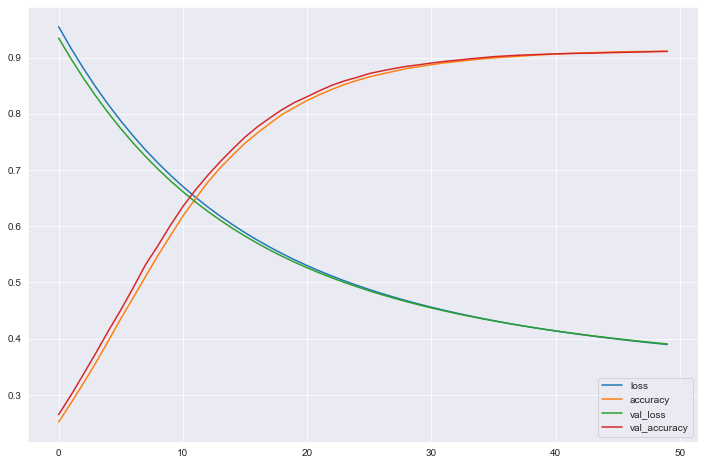

In [27]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.show()

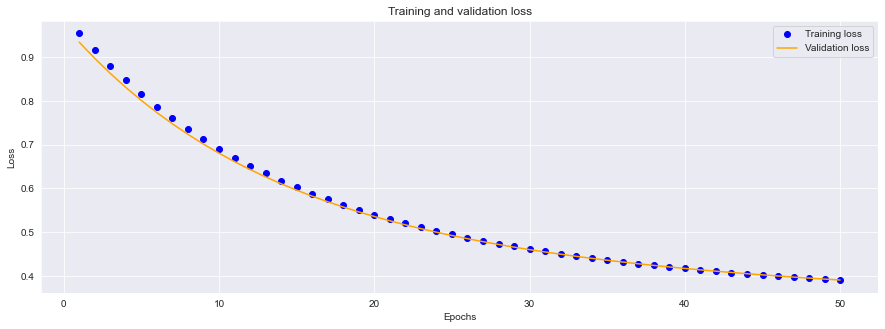

In [28]:
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

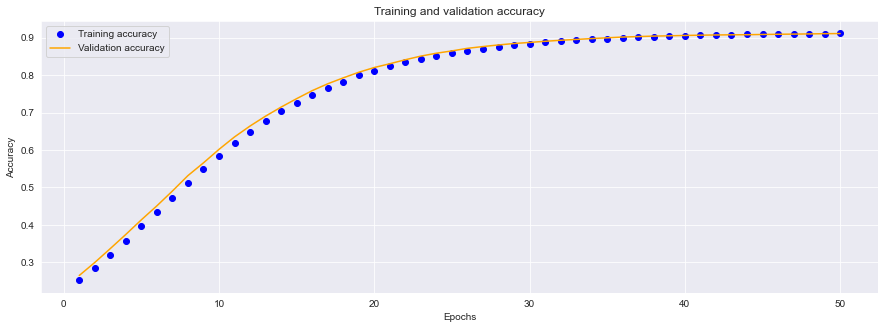

0.9108217358589172

In [29]:
# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)

In [36]:
y_hat = NeuralNetwork.predict(X_test)
y_hat = np.where(y_hat>0.5,1,0)

540/540 [==============================] - 1s 1ms/step


In [37]:
cf_matrix = confusion_matrix(y_test, y_hat)
print(classification_report(y_test, y_hat))

print("Mean Absolute Error: ", mean_absolute_error(y_test, y_hat))
print("Mean Square Error: ", mean_squared_error(y_test, y_hat))
print("Accuracy Score: ", accuracy_score(y_test, y_hat))
print("Recall Score: ", recall_score(y_test, y_hat, average=None))
print("precision Score: ", precision_score(y_test, y_hat, average=None))
print("AUC-ROC Curve: ", roc_auc_score(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     15788
           1       0.16      0.01      0.02      1492

    accuracy                           0.91     17280
   macro avg       0.54      0.50      0.48     17280
weighted avg       0.85      0.91      0.87     17280

Mean Absolute Error:  0.08917824074074074
Mean Square Error:  0.08917824074074074
Accuracy Score:  0.9108217592592592
Recall Score:  [0.99613631 0.0080429 ]
precision Score:  [0.91398849 0.16438356]
AUC-ROC Curve:  0.5020896007487955


<AxesSubplot:>

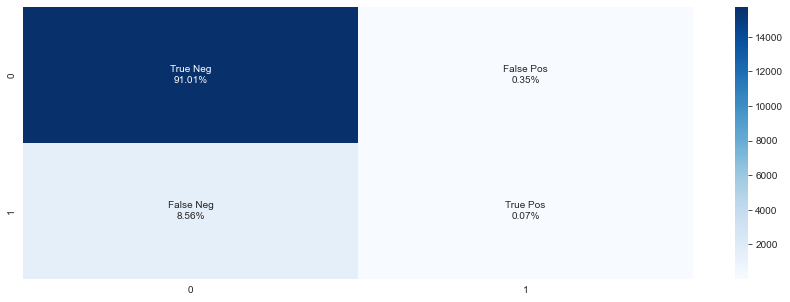

In [38]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')